In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
data = pd.read_csv('./Data/Wireless Eye Data/Training Data/nLoS/combined2_training.csv')

# Preprocess the data
# Assuming 'activity' is the target column and the rest are features
X = data.drop(['timestamp','activity'], axis=1).values
y = data['activity'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset class
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ActivityDataset(X_train, y_train)
test_dataset = ActivityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        default: zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y))

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Compute accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Average loss and accuracy for the epoch
    epoch_loss /= len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')
print("done")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect true labels and predictions
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

Epoch [1/100], Loss: 0.5471, Accuracy: 76.20%
Epoch [2/100], Loss: 0.3484, Accuracy: 85.96%
Epoch [3/100], Loss: 0.2769, Accuracy: 89.09%
Epoch [4/100], Loss: 0.2300, Accuracy: 90.96%
Epoch [5/100], Loss: 0.1958, Accuracy: 92.47%
Epoch [6/100], Loss: 0.1679, Accuracy: 93.58%
Epoch [7/100], Loss: 0.1475, Accuracy: 94.45%
Epoch [8/100], Loss: 0.1295, Accuracy: 95.18%
Epoch [9/100], Loss: 0.1156, Accuracy: 95.74%
Epoch [10/100], Loss: 0.1038, Accuracy: 96.25%
Epoch [11/100], Loss: 0.0949, Accuracy: 96.52%
Epoch [12/100], Loss: 0.0866, Accuracy: 96.84%
Epoch [13/100], Loss: 0.0792, Accuracy: 97.13%
Epoch [14/100], Loss: 0.0735, Accuracy: 97.32%
Epoch [15/100], Loss: 0.0706, Accuracy: 97.47%
Epoch [16/100], Loss: 0.0646, Accuracy: 97.68%
Epoch [17/100], Loss: 0.0627, Accuracy: 97.77%
Epoch [18/100], Loss: 0.0592, Accuracy: 97.88%
Epoch [19/100], Loss: 0.0564, Accuracy: 98.01%
Epoch [20/100], Loss: 0.0538, Accuracy: 98.10%
Epoch [21/100], Loss: 0.0533, Accuracy: 98.12%
Epoch [22/100], Loss: 

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

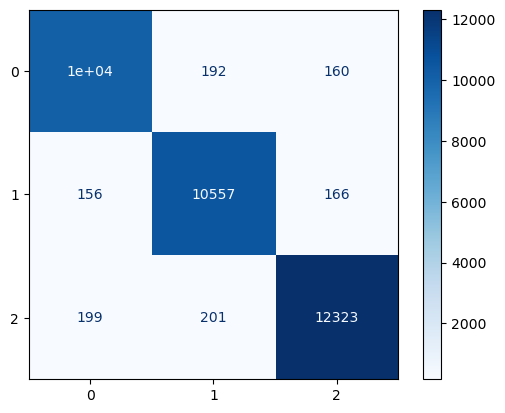

In [2]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [4]:
print("Confusion matrix shape:", cm.shape)
print("Number of classes:", len(le.classes_))

Confusion matrix shape: (3, 3)
Number of classes: 4


In [6]:
print(le.classes_)

['Running' 'Standing' 'Walking' nan]


In [5]:
# Check unique classes in test labels
unique_test_classes = np.unique(y_test)
print("Unique classes in test set:", unique_test_classes)

# Compare with all classes
unique_train_classes = np.unique(y_train)
print("Unique classes in training set:", unique_train_classes)

Unique classes in test set: [0 1 2]
Unique classes in training set: [0 1 2 3]


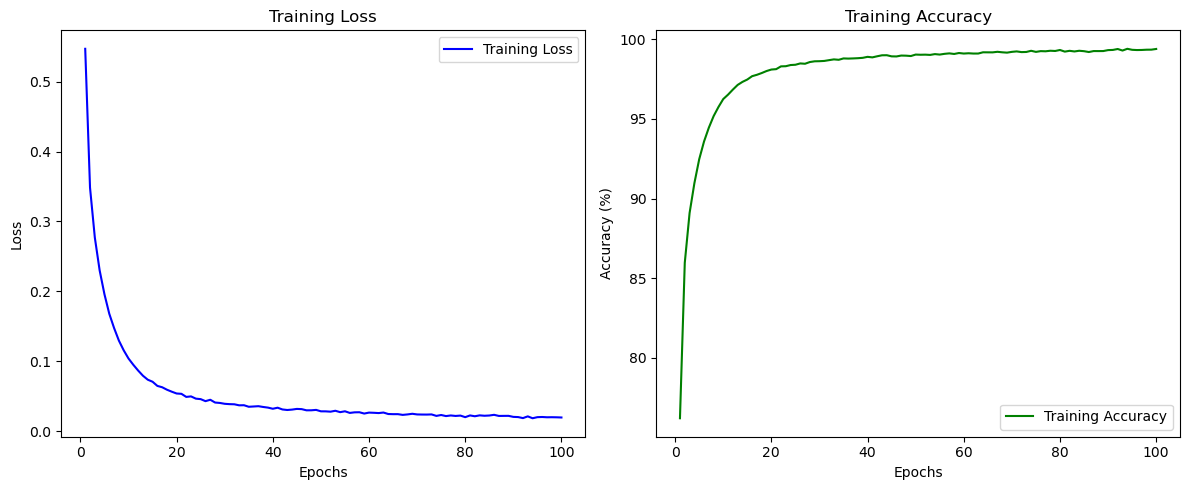

In [3]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()